# Bitcoin Time Series Prediction with LSTM

In [ ]:

!pip3 install keras

In [ ]:
!sudo pip3 install pandas

In [ ]:
%bash
pip install  plotly

In [ ]:
!pip3 install  seaborn

In [ ]:
!sudo pip3 install numpy

In [ ]:
!sudo pip3 install sklearn

In [ ]:
!sudo pip3 install tensorflow

In [ ]:
!pip3 install  quandl

In [ ]:
%bash
which pip3

#### Import necessary library needed for the model training

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


#### Use Quandl api to get BTC/USD data from kraken exchange

In [2]:
import quandl
data = quandl.get('BCHARTS/KRAKENUSD', returns='pandas')

In [3]:
bitcoin_data= quandl.get('BITFINEX/BTCUSD',returns='pandas')
eth_data= quandl.get("BITFINEX/ETHUSD",returns='pandas')

#### Read data set

In [4]:
data1 = pd.read_csv(filepath_or_buffer="bitcoinprices.txt",names=['stamp','price'])
data2 = pd.read_csv(filepath_or_buffer="sentiment6.txt",names=['stamp','sentiment'])

#### View data info

In [5]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 657 entries, 0 to 656
Data columns (total 2 columns):
stamp    657 non-null int64
price    657 non-null float64
dtypes: float64(1), int64(1)
memory usage: 10.3 KB


In [6]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643 entries, 0 to 642
Data columns (total 2 columns):
stamp        643 non-null int64
sentiment    643 non-null object
dtypes: int64(1), object(1)
memory usage: 10.1+ KB


In [7]:

#Remove any entries with sentiment=None
data2.drop( data2.index[data2['sentiment'].str.contains("None") ]  ,axis=0,inplace=True)

In [8]:
data2[data2['sentiment'].str.contains("None") ]

,stamp,sentiment


In [9]:
data2.info()
data2.dropna(axis=1,how='all')
data2['sentiment'] = data2.sentiment.astype(float)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642 entries, 0 to 642
Data columns (total 2 columns):
stamp        642 non-null int64
sentiment    642 non-null object
dtypes: int64(1), object(1)
memory usage: 15.0+ KB


#### View data rows

In [10]:
data1.head()

,stamp,price
0,20160227,427.1
1,20161118,750.9
2,20160613,690.9
3,20160808,588.7
4,20170206,1047.3


In [11]:
data2.head()

,stamp,sentiment
0,20171114,0.380219
1,20171113,0.380219
2,20171112,0.380219
3,20171111,0.380219
4,20171110,0.380219


#### Join on data frame

In [12]:
data = pd.merge(data1,data2, on='stamp', how='inner')


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642 entries, 0 to 641
Data columns (total 3 columns):
stamp        642 non-null int64
price        642 non-null float64
sentiment    642 non-null float64
dtypes: float64(2), int64(1)
memory usage: 20.1 KB


In [14]:
data.describe()

,stamp,price,sentiment
count,6.420000e+02,642.000000,642.000000
mean,2.016562e+07,1624.166199,0.302743
std,4.941961e+03,1601.722683,0.095576
min,2.016021e+07,379.200000,-0.040372
25%,2.016072e+07,603.500000,0.249838
50%,2.016123e+07,868.400000,0.305277
75%,2.017061e+07,2359.250000,0.379694
max,2.017111e+07,7489.900000,0.518510


In [15]:
data['stamp'] = pd.to_datetime(data['stamp'].apply(str),format='%Y%m%d')
data = data.sort_values(by='stamp', ascending=[ True])



data.head()


,stamp,price,sentiment
573,2016-02-11,379.2,0.306488
427,2016-02-12,389.0,0.260142
212,2016-02-13,397.7,0.304902
113,2016-02-14,406.8,0.308635
590,2016-02-15,400.9,0.321268


In [16]:
dataM=pd.DataFrame(columns=['Time', 'Price', 'Sentiment'])

dataM['Time'] = data['stamp']
dataM['Price']=data['price']
dataM['Sentiment']=data['sentiment']


dataM.to_csv("merged_data.csv")

#### Plot line graph base on `Weighted Price`

In [17]:
btc_trace = go.Scatter(x=data['stamp'], y=data['price'], name= 'Price')
py.iplot([btc_trace])

#### Fill value 0 data points on `Weighted Price` with NAN and then use ffill method to fill values

In [18]:
data['price'].replace(0, np.nan, inplace=True)
data['price'].fillna(method='ffill', inplace=True)

#### Plot new line graph again on `Weighted Price` with newly filled values

In [19]:
btc_trace = go.Scatter(x=data['stamp'], y=data['price'], name= 'Price')
py.iplot([btc_trace])

In [20]:
data.head()

,stamp,price,sentiment
573,2016-02-11,379.2,0.306488
427,2016-02-12,389.0,0.260142
212,2016-02-13,397.7,0.304902
113,2016-02-14,406.8,0.308635
590,2016-02-15,400.9,0.321268


### Using `Weighted Price` as a feature to train the LSTM model 

#### Use MinMaxScaler to normalize `Weighted Price` to range from 0 to 1

In [59]:
from sklearn.preprocessing import MinMaxScaler
values = data['price'].values.reshape(-1,1)
sentiment = data['sentiment'].values.reshape(-1,1)
values = values.astype('float32')
sentiment = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [60]:
data['price'].shape

(642,)

In [61]:
scaled.shape

(642, 1)

In [62]:
btc_trace_scaled = go.Scatter(x=data['stamp'], y=scaled.reshape(-1), name= 'Price')
py.iplot([btc_trace_scaled])

#### Split 70% of data for training and 30% for testing

In [63]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))
split = train_size

449 193


In [64]:
scaled[0:3]

array([[ 0.        ],
       [ 0.0013782 ],
       [ 0.00260171]], dtype=float32)

In [75]:
sentiment[0:3,:]

array([[ 379.20001221],
       [ 389.        ],
       [ 397.70001221]], dtype=float32)

#### Create function for creating dataset with look back

In [66]:
def create_dataset(dataset, look_back, sentiment):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        np.append(a,sentiment[i])
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

#### Generate dataset for trainX, trainY, testX, testY

In [67]:
look_back = 1
trainX, trainY = create_dataset(train, look_back, sentiment[0:train_size])
testX, testY = create_dataset(test, look_back, sentiment[train_size:len(scaled)])

448
192


In [76]:
trainX[0:10,:]

array([[ 0.        ],
       [ 0.0013782 ],
       [ 0.00260171],
       [ 0.00388147],
       [ 0.00305174],
       [ 0.0045987 ],
       [ 0.00551281],
       [ 0.00541438],
       [ 0.00656756],
       [ 0.00843799]], dtype=float32)

In [77]:
trainY[0:10]

array([ 0.0013782 ,  0.00260171,  0.00388147,  0.00305174,  0.0045987 ,
        0.00551281,  0.00541438,  0.00656756,  0.00843799,  0.00838173], dtype=float32)

In [78]:
sentiment[0:10]

array([[ 379.20001221],
       [ 389.        ],
       [ 397.70001221],
       [ 406.79998779],
       [ 400.8999939 ],
       [ 411.8999939 ],
       [ 418.3999939 ],
       [ 417.70001221],
       [ 425.8999939 ],
       [ 439.20001221]], dtype=float32)

#### Reshape X for model training

In [29]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#### Running the LSTM model with 300 epochs

In [30]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

#### Plot line graph to show amount loss according the the epoch

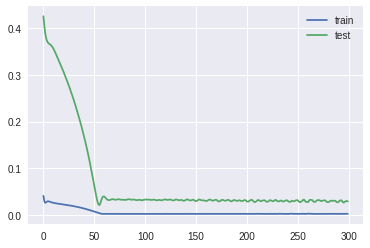

In [31]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#### Make prediction using textX and plotting line graph against testY

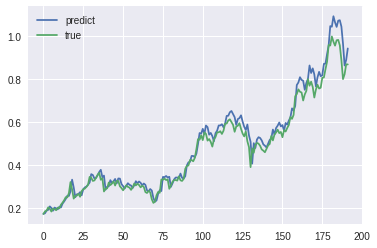

In [32]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

#### Scaler Inverse Y back to normal value

In [33]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

#### RMSE

In [34]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 292.165


#### Plot line graph with Y as USD

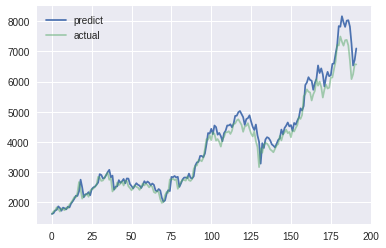

In [35]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

#### Convert X to dates

In [36]:
predictDates = data.tail(len(testX)).stamp

#### Reshape testY and yhat for plotly

In [37]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

#### Plot predicted and actual line graph with X=dates, Y=USD

In [38]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

### Using additional features for model training

#### Find corrleration in features to `Weighted Price`

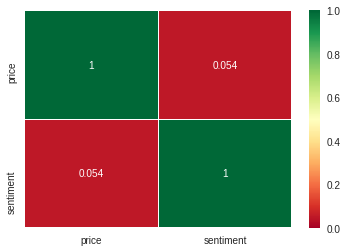

In [39]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

Observation: `Volume` is corrlerated to `Weighted Price`. 
`Open`, `High`, `Low`, `Close` are directly related to `Weighted Price`

#### Function to convert series to supervised learning

In [40]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### Get all data values

In [41]:
values = data[['price']].values
values = values.astype('float32')

#### Normalize features to range from 0 to 1

In [42]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#### Frame as supervised learning

In [43]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var1(t)
1,0.000000,0.001378
2,0.001378,0.002602
3,0.002602,0.003881
4,0.003881,0.003052
5,0.003052,0.004599


#### Drop unncessary columns 

In [44]:
#reframed.drop(reframed.columns[[1,3]], axis=1, inplace=True)
#print(reframed.head())

#### Split data to 70% training, 30% testing

In [45]:
values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(448, 1, 1) (448,) (193, 1, 1) (193,)


#### Training the LSTM model with 300 epochs

In [46]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=300, batch_size=100, validation_data=(test_X, test_y), verbose=0, shuffle=False)

#### Plot line graph to show amount loss according the the epoch

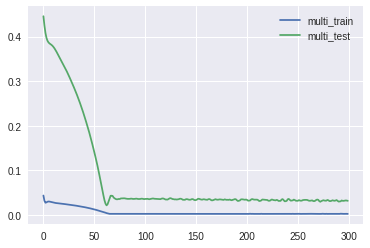

In [47]:
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

#### Make prediction using textX and plotting line graph against testY

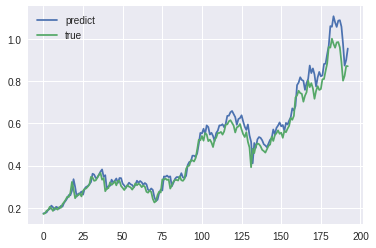

In [48]:
yhat = multi_model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

#### Scaler Inverse Y back to normal value

In [49]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#### RMSE

In [50]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 316.302


#### Plot line graph with actual price, predicted price with feature `Weighted Price`, predicted price with features `Volume` and `Weighted Price`

In [51]:
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, multi_predict_chart, actual_chart])

- LSTM with single feature of `Weighted Price` have RMSE of 159.194
- LSTM with features of `Volume(BTC)`, `Volume(Currency)` and `Weighted Price` have RMSE of 96.184
- LSTM with multi features shows more accurate results as show in line chart above